# Necassary Imports

In [1]:
# Imports
import gensim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

import re
#import inflect
#from num2words import num2words
from nltk.corpus import stopwords
from collections import Counter

import sklearn

from gensim.models import Word2Vec

from sklearn.model_selection import ParameterSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import RandomizedSearchCV

from nltk.stem import WordNetLemmatizer
import nltk 


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\netha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\netha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\netha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Necassary preprocessing steps

In [2]:
# Import data
df = pd.read_csv('us_equities_news_dataset.csv')

In [3]:
# Filter out Nvidia articles
nvidia_df = df[df['title'].str.contains('NVIDIA|NVDA', case=False, na=False) |
               df['content'].str.contains('NVIDIA|NVDA', case=False, na=False) |
               df['ticker'].str.contains('NVIDIA|NVDA', case=False, na=False)]

In [4]:
print(len(nvidia_df))

3464


In [5]:
#Pre processing steps
def preprocess_text_iteration1(text):
    text = text.strip()
    # Replace URLs with an empty string
    re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    words = word_tokenize(text.lower())
    #check if the word is alpha numeric
    alpha_words = [word for word in words if word.isalpha()]
    #remove numbers
    numbers_words = [word for word in alpha_words if not word.isdigit()]
    return numbers_words

# apply preprocessing
nvidia_df['content'] = nvidia_df['content'].apply(preprocess_text_iteration1)

C:\Users\netha\AppData\Local\Temp\ipykernel_9888\2317645968.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nvidia_df['content'] = nvidia_df['content'].apply(preprocess_text_iteration1)


## LDA

In [6]:
#create a document term matrix
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(nvidia_df['content'].apply(lambda x: ' '.join(x)))
print(X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


[['the', 'to', 'nasdaq', 'at', 'nyse', 'on', 'was', 'inc', 'and', 'in'], ['the', 'to', 'and', 'of', 'in', 'that', 'is', 'on', 'for', 'it'], ['the', 'of', 'and', 'in', 'to', 'for', 'on', 'is', 'as', 'that'], ['the', 'of', 'to', 'and', 'in', 'zacks', 'is', 'year', 'company', 'for'], ['the', 'to', 'and', 'of', 'in', 'that', 'is', 'for', 'with', 'its']]
Topic 0: the to nasdaq at nyse on was inc and in
Topic 1: the to and of in that is on for it
Topic 2: the of and in to for on is as that
Topic 3: the of to and in zacks is year company for
Topic 4: the to and of in that is for with its
[[3.33679444e-04 9.98672051e-01 3.31530940e-04 3.32240994e-04
  3.30497360e-04]
 [1.46724347e-02 9.84048657e-01 4.24542898e-04 4.25398167e-04
  4.28967212e-04]
 [1.17503317e-01 1.57607207e-01 6.83934649e-01 4.47099975e-04
  4.05077274e-02]
 ...
 [3.06023673e-04 6.26508095e-02 6.73968436e-01 2.62765056e-01
  3.09674869e-04]
 [1.44314196e-04 3.58371492e-03 8.02585662e-01 1.93541172e-01
  1.45136982e-04]
 [2.463

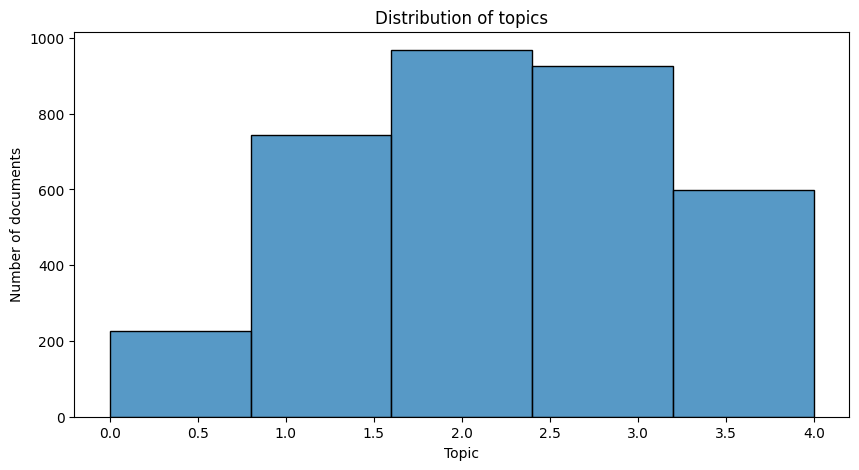

In [7]:
# train LDAModel
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(X)

# get topics
def get_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names_out()
    topics = []
    for topic in model.components_:
        topic_words = [words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append(topic_words)
    return topics

topics = get_topics(lda, vectorizer, 10)
print(topics)
for i, topic in enumerate(topics):
    print('Topic {}: {}'.format(i, ' '.join(topic)))


# get topic distribution for each document
topic_dist = lda.transform(X)
print(topic_dist)

# plot the distribution of topics
plt.figure(figsize=(10, 5))
sns.histplot(topic_dist.argmax(axis=1), bins=5)
plt.xlabel('Topic')
plt.ylabel('Number of documents')
plt.title('Distribution of topics')
plt.show()



In [8]:
# create a cluster plot for the topics

#if we have more time we look this because it is a cool plot (we don't fully understand it because copilot made it)

# from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2, random_state=0)
# tsne_embedding = tsne.fit_transform(topic_dist)
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=tsne_embedding[:, 0], y=tsne_embedding[:, 1], hue=topic_dist.argmax(axis=1), palette='tab10')
# plt.xlabel('t-SNE component 1')
# plt.ylabel('t-SNE component 2')
# plt.title('t-SNE plot of topics')
# plt.show()

## FLSA-W

In [9]:
# FuzzyTM FLSA-W
from FuzzyTM import FLSA_W

# Coherence and Diversity

In [10]:


# create a FLSA-W model
flsaW = FLSA_W(
input_file = nvidia_df['content'].to_list(),
num_topics=5,
num_words=10,
)

In [11]:
flsaW.get_vocabulary_size()
pwgt, ptgd = flsaW.get_matrices() # THIS TRAINS THE MODEL
print(flsaW.show_topics())


[(0, '0.0019*"nvda" + 0.0019*"nvidia" + 0.0017*"com" + 0.0017*"nasdaq" + 0.0016*"shares" + 0.0015*"nyse" + 0.0015*"advanced" + 0.0015*"days" + 0.0015*"during" + 0.0015*"p"'), (1, '0.0008*"traded" + 0.0007*"reuters" + 0.0007*"exchange" + 0.0006*"composite" + 0.0006*"session" + 0.0006*"chipmaker" + 0.0006*"rose" + 0.0006*"blast" + 0.0006*"previously" + 0.0006*"bell"'), (2, '0.0005*"gmt" + 0.0004*"outnumbered" + 0.0003*"performers" + 0.0003*"settle" + 0.0003*"the" + 0.0003*"to" + 0.0003*"slumped" + 0.0003*"in" + 0.0003*"of" + 0.0003*"a"'), (3, '0.0002*"the" + 0.0002*"to" + 0.0002*"in" + 0.0002*"of" + 0.0002*"a" + 0.0002*"and" + 0.0002*"on" + 0.0002*"for" + 0.0002*"s" + 0.0002*"with"'), (4, '0.009*"book" + 0.0077*"evolution" + 0.0075*"books" + 0.0071*"richard" + 0.0066*"science" + 0.006*"certainty" + 0.0056*"modern" + 0.0055*"professor" + 0.005*"me" + 0.0045*"beliefs"')]


## Compute Diversity, Coherence, Interpretability for FLSA-W and LDA

In [12]:
for topic in flsaW.show_topics(representation='words'):
    print(topic)


print(flsaW.get_coherence_score()) # ask if this has to be high
print(flsaW.get_diversity_score()) # ask if this has to be high
print(flsaW.get_interpretability_score()) # ask if this has to be high




['nvda', 'nvidia', 'com', 'nasdaq', 'shares', 'nyse', 'advanced', 'days', 'during', 'p']
['traded', 'reuters', 'exchange', 'composite', 'session', 'chipmaker', 'rose', 'blast', 'previously', 'bell']
['gmt', 'outnumbered', 'performers', 'settle', 'the', 'to', 'slumped', 'in', 'of', 'a']
['the', 'to', 'in', 'of', 'a', 'and', 'on', 'for', 's', 'with']
['book', 'evolution', 'books', 'richard', 'science', 'certainty', 'modern', 'professor', 'me', 'beliefs']
0.41443719248642524
0.9
0.3729934732377827


In [13]:
#coherence for lda (we make sure tha the content is the same as the content used to train FLSA-W and LDA)
coherence_lda = flsaW.get_coherence_score(
nvidia_df['content'].to_list(),
topics)

print(coherence_lda)


0.32606610536545527


In [14]:
#diversity for lda (we make sure tha the content is the same as the content used to train FLSA-W and LDA)
diversity_lda = flsaW.get_diversity_score(topics)
print(diversity_lda)

0.42


In [15]:
#lda interpretability
interpretability_lda = diversity_lda * coherence_lda
print(interpretability_lda)

0.1369477642534912


## Elbow plots (FLSA-W and LDA)

for now we don't do this with BERT, it causes issues when running the coherence as it checks over several words. This could be due to the topics that BERT finds.

### FLSA-W

1
2
3
4
5
6
7
8
9
10


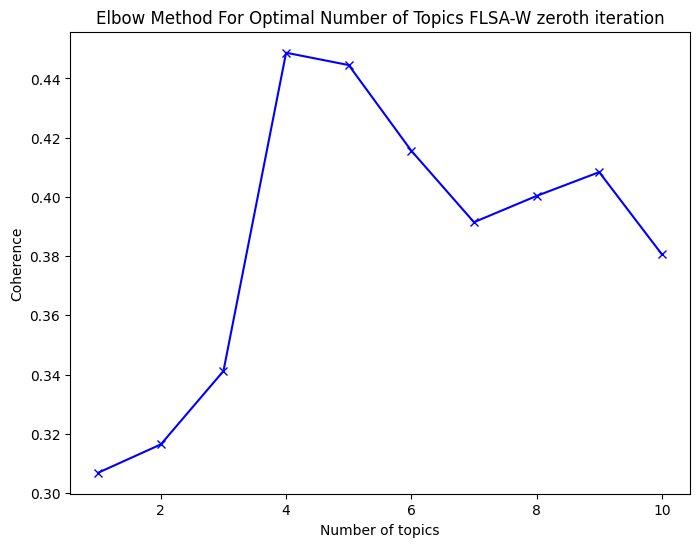

In [16]:
#elbow plot for coherence

#elbow plot for FLSA-W
range_n_topics = range(1, 11)

# Create a list of coherence values
coherences = []
for n_topics in range_n_topics:
    #train model
    print(n_topics)
    flsaW_elbow = FLSA_W(
    input_file = nvidia_df['content'].to_list(),
    num_topics=n_topics,
    num_words=10,
    )
    #get coherence
    flsaW_elbow.get_vocabulary_size()
    pwgt, ptgd = flsaW_elbow.get_matrices() # THIS TRAINS THE MODEL
    coherence = flsaW_elbow.get_coherence_score()
    coherences.append(coherence)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, coherences, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Coherence')
plt.title('Elbow Method For Optimal Number of Topics FLSA-W zeroth iteration')
plt.show()


1
2
3
4
5
6
7
8
9
10


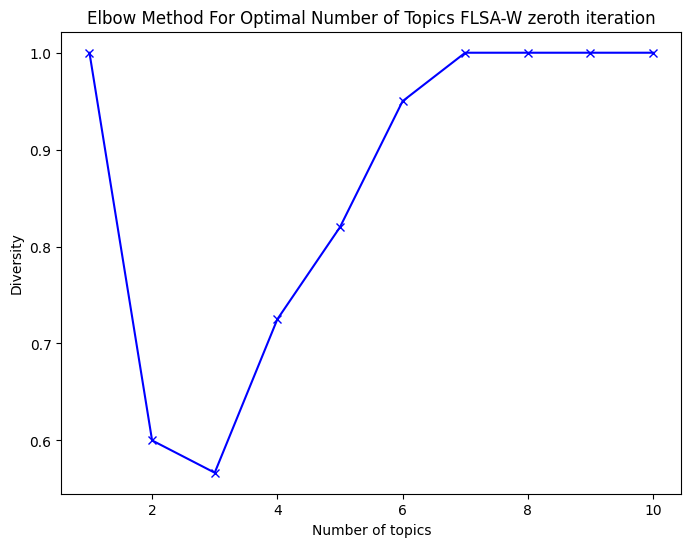

In [17]:
#elbow plot for diversity

#elbow plot for FLSA-W

# Create a list of diversity values
diversities = []
for n_topics in range_n_topics:
    print(n_topics)
    #train model
    flsaW_elbow = FLSA_W(
    input_file = nvidia_df['content'].to_list(),
    num_topics=n_topics,
    num_words=10,
    )
    flsaW_elbow.get_vocabulary_size()
    pwgt, ptgd = flsaW_elbow.get_matrices() # THIS TRAINS THE MODEL
    #get diversity
    diversity = flsaW_elbow.get_diversity_score()
    diversities.append(diversity)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, diversities, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Diversity')
plt.title('Elbow Method For Optimal Number of Topics FLSA-W zeroth iteration')
plt.show()


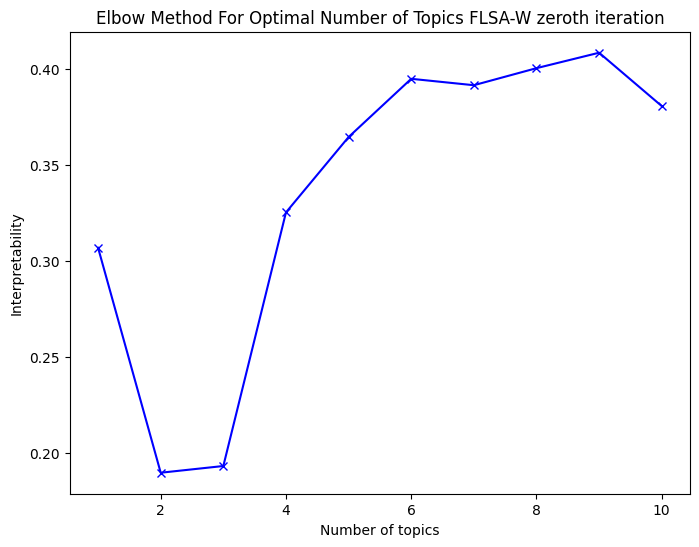

In [18]:
#elbow plot for interpretability

#elbow plot for FLSA-W
interpretabilities = []
for i in range_n_topics:
    interpretability = coherences[i-1] * diversities[i-1]
    interpretabilities.append(interpretability)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, interpretabilities, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Interpretability')
plt.title('Elbow Method For Optimal Number of Topics FLSA-W zeroth iteration')
plt.show()



### LDA

1
2
3
4
5
6
7
8
9
10


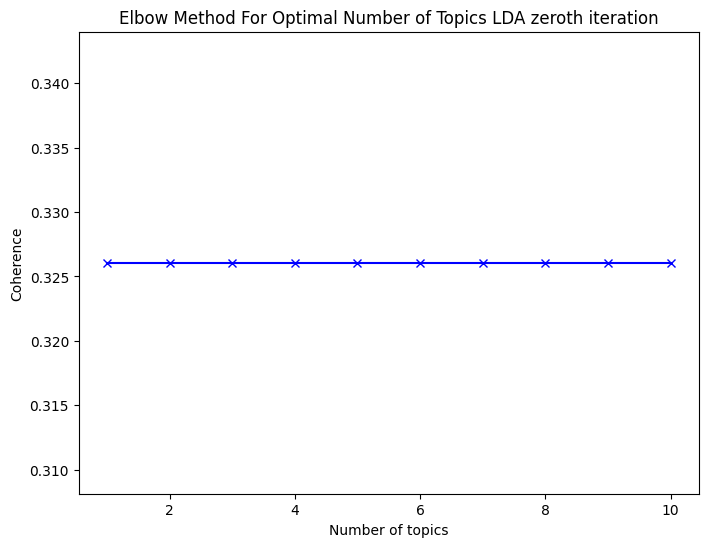

In [19]:
#elbow plot for coherence

#elbow plot for LDA
range_n_topics = range(1, 11)

# Create a list of coherence values
coherences = []
for n_topics in range_n_topics:
    print(n_topics)
    #train model
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
    lda.fit(X)
    #get coherence
    coherence = flsaW.get_coherence_score(
    nvidia_df['content'].to_list(),
    topics)
    coherences.append(coherence)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, coherences, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Coherence')
plt.title('Elbow Method For Optimal Number of Topics LDA zeroth iteration')
plt.show()


1
2
3
4
5
6
7
8
9
10


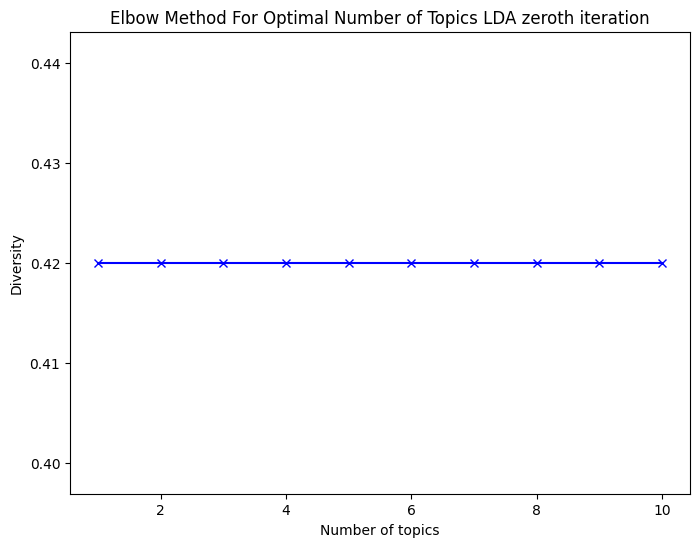

In [20]:
#elbow plot for diversity

#elbow plot for LDA
range_n_topics = range(1, 11)

# Create a list of diversity values
diversities = []
for n_topics in range_n_topics:
    print(n_topics)
    #train model
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
    lda.fit(X)
    #get diversity
    diversity = flsaW.get_diversity_score(
    
    topics)
    diversities.append(diversity)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, diversities, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Diversity')
plt.title('Elbow Method For Optimal Number of Topics LDA zeroth iteration')
plt.show()

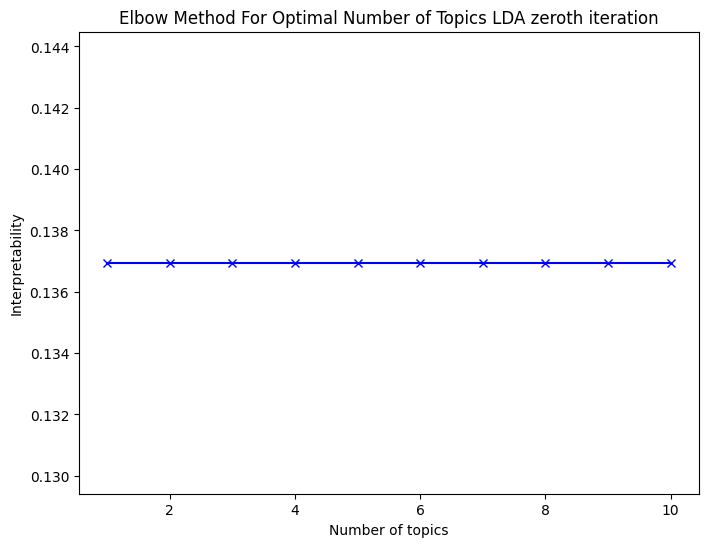

In [21]:
#elbow plot for interpretability

#elbow plot for LDA
interpretabilities = []
for i in range_n_topics:
    interpretability = coherences[i-1] * diversities[i-1]
    interpretabilities.append(interpretability)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, interpretabilities, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Interpretability')
plt.title('Elbow Method For Optimal Number of Topics LDA zeroth iteration')
plt.show()

## Bert Topic

In [22]:
from bertopic import BERTopic
from umap import UMAP
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=0)
docs = [' '.join(doc) for doc in nvidia_df['content']]
# Create the model (uses DistilBERT by default)
bert_topic = BERTopic(umap_model=umap_model)
# Train the model and transform your data into topics
topic_assigned_to_doc, _ = bert_topic.fit_transform(docs)
topic_matrix = bert_topic.get_topic_info()
bert_topic.get_topics()



c:\Users\netha\OneDrive - TU Eindhoven\School\2024-2025\NLP\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{-1: [('the', 0.013273319166562299),
  ('and', 0.012404216732045701),
  ('of', 0.011967628391120566),
  ('to', 0.011604600628060815),
  ('in', 0.011447234789884306),
  ('is', 0.009547451253041269),
  ('for', 0.009515872842392054),
  ('that', 0.009214276722087838),
  ('on', 0.00851816463251642),
  ('with', 0.008294464077235341)],
 0: [('nvidia', 0.022496401580217724),
  ('gaming', 0.01293051267094729),
  ('the', 0.012579325455493891),
  ('of', 0.012532446234892521),
  ('to', 0.012289698739480942),
  ('in', 0.011856642587846371),
  ('and', 0.01081231795219225),
  ('its', 0.010601431658602173),
  ('is', 0.01019330888293089),
  ('for', 0.010190180531630672)],
 1: [('the', 0.014885756844871435),
  ('on', 0.012300078037187568),
  ('to', 0.011450981426557214),
  ('week', 0.011089374625402715),
  ('fed', 0.010985819898775558),
  ('in', 0.010466141664402132),
  ('of', 0.009720831090548256),
  ('that', 0.009718970438368238),
  ('and', 0.00962616365884583),
  ('percent', 0.009386566468787974)],
 

In [23]:
print(topic_matrix)

    Topic  Count                                Name  \
0      -1    822                    -1_the_and_of_to   
1       0    433              0_nvidia_gaming_the_of   
2       1    131                    1_the_on_to_week   
3       2    126     2_million_quarter_revenues_year   
4       3    120                   3_tech_the_of_and   
..    ...    ...                                 ...   
62     61     12  61_western_digital_sandisk_storage   
63     62     12       62_blockchain_etf_etfs_kensho   
64     63     12       63_resistance_around_stock_is   
65     64     12             64_traded_at_nvidia_gmt   
66     65     12       65_notes_cash_offering_senior   

                                       Representation  \
0     [the, and, of, to, in, is, for, that, on, with]   
1   [nvidia, gaming, the, of, to, in, and, its, is...   
2   [the, on, to, week, fed, in, of, that, and, pe...   
3   [million, quarter, revenues, year, company, za...   
4   [tech, the, of, and, in, nasdaq, is, s

In [24]:
bert_topic.visualize_heatmap(n_clusters=15)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'coloraxis': 'coloraxis',
              'hovertemplate': 'x: %{x}<br>y: %{y}<br>Similarity Score: %{z}<extra></extra>',
              'name': '0',
              'type': 'heatmap',
              'x': [0_nvidia_gaming_the, 29_mellanox_ethernet_switches,
                    39_mining_ethereum_cryptocu..., 1_the_on_to,
                    11_trade_china_trump, 22_futures_points_et, 43_lunch_dave_on,
                    63_resistance_around_stock, 2_million_quarter_revenues,
                    36_million_year_quarter, 48_ansys_million_simulation,
                    51_storage_pure_quarter, 61_western_digital_sandisk,
                    3_tech_the_of, 4_analyst_zacks_and,
                    6_semiconductor_earnings_has, 16_earnings_nyse_the,
                    31_nyse_nasdaq_after, 42_after_stock_nasdaq,
                    5_apple_iphone_the, 8_intel_and_to, 10_amd_we_year,
                    13_micron_dram_nand, 35_tsmc_samsung_taiwan,
                    45_broadcom_quarter_revenues, 7_performers_which_close,
                    9_the_this_of, 15_resistance_roku_stock, 19_day_trading_above,
                    28_you_week_this, 32_index_the_dow, 33_percent_dow_after,
                    34_inc_it_nasdaq, 12_tracey_value_podcast,
                    17_earnings_estimates_eps, 14_china_chinese_huawei,
                    24_bitcoin_blockchain_crypt..., 54_china_chip_semiconductor,
                    58_coronavirus_china_and, 62_blockchain_etf_etfs,
                    18_amd_radeon_graphics, 46_intel_hp_core,
                    20_driving_self_autonomous, 26_driving_self_autonomous,
                    59_baidu_apollo_driving, 21_games_gaming_game,
                    23_ai_robotics_and, 44_google_alphabet_it,
                    47_cadence_design_verificat..., 55_tesla_musk_vice,
                    56_qualcomm_intel_modem, 57_mobileye_driving_autonom...,
                    25_facebook_users_user, 41_qualcomm_commission_pate...,
                    53_softbank_fund_vision, 65_notes_cash_offering,
                    27_traded_at_nvidia, 30_traded_at_nvidia, 37_traded_at_nvidia,
                    40_traded_at_nvidia, 50_traded_at_nvidia, 60_traded_at_nvidia,
                    64_traded_at_nvidia, 38_us_targets_scenario,
                    52_rallied_australian_climbed, 49_earnings_or_growth],
              'xaxis': 'x',
              'y': [0_nvidia_gaming_the, 29_mellanox_ethernet_switches,
                    39_mining_ethereum_cryptocu..., 1_the_on_to,
                    11_trade_china_trump, 22_futures_points_et, 43_lunch_dave_on,
                    63_resistance_around_stock, 2_million_quarter_revenues,
                    36_million_year_quarter, 48_ansys_million_simulation,
                    51_storage_pure_quarter, 61_western_digital_sandisk,
                    3_tech_the_of, 4_analyst_zacks_and,
                    6_semiconductor_earnings_has, 16_earnings_nyse_the,
                    31_nyse_nasdaq_after, 42_after_stock_nasdaq,
                    5_apple_iphone_the, 8_intel_and_to, 10_amd_we_year,
                    13_micron_dram_nand, 35_tsmc_samsung_taiwan,
                    45_broadcom_quarter_revenues, 7_performers_which_close,
                    9_the_this_of, 15_resistance_roku_stock, 19_day_trading_above,
                    28_you_week_this, 32_index_the_dow, 33_percent_dow_after,
                    34_inc_it_nasdaq, 12_tracey_value_podcast,
                    17_earnings_estimates_eps, 14_china_chinese_huawei,
                    24_bitcoin_blockchain_crypt..., 54_china_chip_semiconductor,
                    58_coronavirus_china_and, 62_blockchain_etf_etfs,
                    18_amd_radeon_graphics, 46_intel_hp_core,
                    20_driving_self_autonomous, 26_driving_self_autonomous,
                    59_baidu_apollo_driving, 21_games_gaming_game,
                    23_ai_robotics_and, 44_google_alphabet_it,
                    47_cadence_design_verif

In [25]:
topic_matrix.head(10)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,822,-1_the_and_of_to,"[the, and, of, to, in, is, for, that, on, with]",[for immediate releasechicago il november zack...
1,0,433,0_nvidia_gaming_the_of,"[nvidia, gaming, the, of, to, in, and, its, is...",[maintaining its earnings streak for the strai...
2,1,131,1_the_on_to_week,"[the, on, to, week, fed, in, of, that, and, pe...",[friday market open have you ever been on a ro...
3,2,126,2_million_quarter_revenues_year,"[million, quarter, revenues, year, company, za...",[keeping its earnings streak alive palo alto n...
4,3,120,3_tech_the_of_and,"[tech, the, of, and, in, nasdaq, is, stocks, t...",[for immediate releasechicago il dec zacks com...
5,4,84,4_analyst_zacks_and_is,"[analyst, zacks, and, is, research, the, of, i...",[for immediate releasechicago il january zacks...
6,5,71,5_apple_iphone_the_to,"[apple, iphone, the, to, in, and, it, of, is, ...",[last week saw apple nasdaq aapl shares jump a...
7,6,67,6_semiconductor_earnings_has_etf,"[semiconductor, earnings, has, etf, the, of, a...",[the semiconductor corner of the broad technol...
8,7,58,7_performers_which_close_inc,"[performers, which, close, inc, at, or, rose, ...",[investing com u s stocks were mixed after the...
9,8,56,8_intel_and_to_the,"[intel, and, to, the, in, of, data, is, that, ...",[this week over of s p companies are set to re...


In [26]:
# print the name of the topic matrix and the representative docs using for loop
for i in range(0, 11):
    print(topic_matrix['Name'][i])
    print(topic_matrix['Representative_Docs'][i])
    print('')

-1_the_and_of_to
['for immediate releasechicago il november zacks com announces the list of stocks featured in the analyst blog every day the zacks equity research analysts discuss the latest news and events impacting stocks and the financial markets stocks recently featured in the blog include nvidia corp nasdaq nvda advanced micro devices nasdaq amd intel nasdaq intc and texas instruments nasdaq txn today zacks is promoting its buy stock recommendations here are highlights from friday s analyst blog nvidia spikes after earnings is it overvalued yesterday after the bell nvidia corp announced solid results topping the zacks consensus estimate by on the top line and on the bottom line both numbers were up strong double digits from the same quarter last year the gaming segment that contributes more than two thirds of its total volume grew as the company saw strength across regions and form factors management also called out strength in the nintendo switch console and cryptocurrencies as 

In [27]:
#create a list of the first 10 representative docs
rep_docs = topic_matrix['Representation'][1:6].to_list()
print(rep_docs)




[['nvidia', 'gaming', 'the', 'of', 'to', 'in', 'and', 'its', 'is', 'for'], ['the', 'on', 'to', 'week', 'fed', 'in', 'of', 'that', 'and', 'percent'], ['million', 'quarter', 'revenues', 'year', 'company', 'zacks', 'of', 'the', 'to', 'and'], ['tech', 'the', 'of', 'and', 'in', 'nasdaq', 'is', 'stocks', 'to', 'this'], ['analyst', 'zacks', 'and', 'is', 'research', 'the', 'of', 'investment', 'in', 'its']]


In [28]:
# #bert coherence --> just say we tried, in the end it doesn't matter I tried hard and got so far 
# print(
# flsaW.get_coherence_score(
# nvidia_df['content'].to_list(),
# rep_docs)
# )


In [29]:
#bert diversity
print(flsaW.get_diversity_score(rep_docs))

0.56


topic